In [3]:
!pip install matplotlib==3.5.3
!pip install numpy==1.21.6
!pip install scipy==1.7.3
!pip install scikit-learn==1.0.2
!pip install seaborn==0.12.1


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
import pickle
import re
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import sklearn

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_theme(style="whitegrid")

# Despues de mucho error debo asegurarme que estoy usando las mismas versiones que PythonAnywhere
assert scipy.__version__ == '1.7.3', "Versión incorrecta de scipy"
assert sklearn.__version__ == '1.0.2', "Versión incorrecta de sklearn"

In [7]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text if text else "no_text"

In [8]:
# Cargar datos
df = pd.read_csv('/Users/deka/Desktop/Apps/ProyectoM7/projectM7/data/processed/processed_reviews.csv')

In [9]:
# Verificar datos cargados
print(f"Dimensiones del DataFrame: {df.shape}")
print("\nColumnas disponibles:")
print(df.columns.tolist())

Dimensiones del DataFrame: (37193, 8)

Columnas disponibles:
['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity', 'Sentiment_Subjectivity', 'Cleaned_Review', 'Processed_Review', 'Review_Length']


In [10]:
# Preprocesar textos
X = df['Processed_Review'].apply(clean_text)
y = df['Sentiment']

In [11]:
# vectorizador
vectorizer = TfidfVectorizer(
    max_features=5000,
    strip_accents='unicode',
    lowercase=True
)

In [12]:
X_vectorized = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

processed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'vectorizer': vectorizer
}

output_path = '/Users/deka/Desktop/Apps/ProyectoM7/data/processed/processed_data_new.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(processed_data, f, protocol=4)

In [14]:
print("\nInformación de los datos guardados:")
print(f"X_train shape: {processed_data['X_train'].shape}")
print(f"X_test shape: {processed_data['X_test'].shape}")
print(f"y_train size: {len(processed_data['y_train'])}")
print(f"y_test size: {len(processed_data['y_test'])}")
print(f"Vectorizer features: {len(processed_data['vectorizer'].get_feature_names())}")

print("\nDistribución de clases:")
print("Train:")
print(pd.Series(processed_data['y_train']).value_counts())
print("\nTest:")
print(pd.Series(processed_data['y_test']).value_counts())


Información de los datos guardados:
X_train shape: (29754, 5000)
X_test shape: (7439, 5000)
y_train size: 29754
y_test size: 7439
Vectorizer features: 5000

Distribución de clases:
Train:
Positive    16463
Neutral      8808
Negative     4483
Name: Sentiment, dtype: int64

Test:
Positive    4116
Neutral     2202
Negative    1121
Name: Sentiment, dtype: int64


In [15]:
# REGRESIÓN LOGÍSTICA
lr_base = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr_base.fit(X_train, y_train)
lr_base_pred = lr_base.predict(X_test)

print("\nResultados del modelo base de regresión logística:")
print(classification_report(y_test, lr_base_pred))


Resultados del modelo base de regresión logística:
              precision    recall  f1-score   support

    Negative       0.84      0.62      0.71      1121
     Neutral       0.72      0.78      0.75      2202
    Positive       0.90      0.92      0.91      4116

    accuracy                           0.84      7439
   macro avg       0.82      0.77      0.79      7439
weighted avg       0.84      0.84      0.83      7439



In [16]:
# Grid Search para regresión logística
lr_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'solver': ['lbfgs', 'newton-cg']
}

lr_grid = GridSearchCV(
    LogisticRegression(multi_class='multinomial', max_iter=1000),
    lr_param_grid,
    cv=5,
    scoring='accuracy'
)

lr_grid.fit(X_train, y_train)
lr_best_pred = lr_grid.predict(X_test)

print("\nMejores parámetros para regresión logística:")
print(lr_grid.best_params_)
print("\nResultados del modelo optimizado de regresión logística:")
print(classification_report(y_test, lr_best_pred))


Mejores parámetros para regresión logística:
{'C': 10.0, 'solver': 'newton-cg'}

Resultados del modelo optimizado de regresión logística:
              precision    recall  f1-score   support

    Negative       0.82      0.74      0.78      1121
     Neutral       0.76      0.80      0.78      2202
    Positive       0.92      0.92      0.92      4116

    accuracy                           0.86      7439
   macro avg       0.83      0.82      0.83      7439
weighted avg       0.86      0.86      0.86      7439



In [17]:
# RANDOM FOREST
rf_base = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_base.fit(X_train, y_train)
rf_base_pred = rf_base.predict(X_test)

print("\nResultados del modelo base Random Forest:")
print(classification_report(y_test, rf_base_pred))


Resultados del modelo base Random Forest:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1121
     Neutral       1.00      0.00      0.00      2202
    Positive       0.55      1.00      0.71      4116

    accuracy                           0.55      7439
   macro avg       0.52      0.33      0.24      7439
weighted avg       0.60      0.55      0.40      7439



In [18]:
# Random Search para Random Forest
rf_param_dist = {
    'n_estimators': [25, 50, 75],  
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42
)
rf_random.fit(X_train, y_train)
rf_best_pred = rf_random.predict(X_test)
print("\nMejores parámetros para Random Forest:")
print(rf_random.best_params_)
print("\nResultados del modelo optimizado Random Forest:")
print(classification_report(y_test, rf_best_pred))


Mejores parámetros para Random Forest:
{'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15}

Resultados del modelo optimizado Random Forest:
              precision    recall  f1-score   support

    Negative       0.97      0.03      0.07      1121
     Neutral       0.71      0.01      0.02      2202
    Positive       0.56      1.00      0.72      4116

    accuracy                           0.56      7439
   macro avg       0.75      0.35      0.27      7439
weighted avg       0.67      0.56      0.41      7439



In [19]:
# NAIVE BAYES
nb_base = MultinomialNB()
nb_base.fit(X_train, y_train)
nb_base_pred = nb_base.predict(X_test)

print("\nResultados del modelo base Naive Bayes:")
print(classification_report(y_test, nb_base_pred))


Resultados del modelo base Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.92      0.25      0.39      1121
     Neutral       0.54      0.42      0.47      2202
    Positive       0.71      0.93      0.81      4116

    accuracy                           0.68      7439
   macro avg       0.72      0.53      0.56      7439
weighted avg       0.69      0.68      0.64      7439



In [20]:
# Grid Search para Naive Bayes
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_param_grid,
    cv=5,
    scoring='accuracy'
)

nb_grid.fit(X_train, y_train)
nb_best_pred = nb_grid.predict(X_test)

print("\nMejores parámetros para Naive Bayes:")
print(nb_grid.best_params_)
print("\nResultados del modelo optimizado Naive Bayes:")
print(classification_report(y_test, nb_best_pred))


Mejores parámetros para Naive Bayes:
{'alpha': 0.1}

Resultados del modelo optimizado Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.86      0.35      0.50      1121
     Neutral       0.55      0.47      0.51      2202
    Positive       0.73      0.91      0.81      4116

    accuracy                           0.69      7439
   macro avg       0.71      0.58      0.61      7439
weighted avg       0.70      0.69      0.67      7439



In [21]:
# ENSAMBLE - Creamos el ensamble con los mejores modelos
ensemble = VotingClassifier(
    estimators=[
        ('logistic', lr_grid.best_estimator_),
        ('random_forest', rf_random.best_estimator_)
    ],
    voting='soft'
)

# Entrenamos el ensamble
ensemble.fit(X_train, y_train)
ensemble_pred = ensemble.predict(X_test)

print("\nResultados del modelo de ensamble:")
print(classification_report(y_test, ensemble_pred))


Resultados del modelo de ensamble:
              precision    recall  f1-score   support

    Negative       0.86      0.69      0.77      1121
     Neutral       0.77      0.75      0.76      2202
    Positive       0.89      0.95      0.92      4116

    accuracy                           0.85      7439
   macro avg       0.84      0.80      0.81      7439
weighted avg       0.85      0.85      0.85      7439



In [22]:
# Resumen de resultados
results = {
    'Logistic Regression Base': classification_report(y_test, lr_base_pred, output_dict=True)['accuracy'],
    'Logistic Regression Optimized': classification_report(y_test, lr_best_pred, output_dict=True)['accuracy'],
    'Random Forest Base': classification_report(y_test, rf_base_pred, output_dict=True)['accuracy'],
    'Random Forest Optimized': classification_report(y_test, rf_best_pred, output_dict=True)['accuracy'],
    'Naive Bayes Base': classification_report(y_test, nb_base_pred, output_dict=True)['accuracy'],
    'Naive Bayes Optimized': classification_report(y_test, nb_best_pred, output_dict=True)['accuracy'],
    'Ensemble': classification_report(y_test, ensemble_pred, output_dict=True)['accuracy']
}

print("\nResumen de accuracy por modelo:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")


Resumen de accuracy por modelo:
Logistic Regression Base: 0.8355
Logistic Regression Optimized: 0.8574
Random Forest Base: 0.5537
Random Forest Optimized: 0.5607
Naive Bayes Base: 0.6782
Naive Bayes Optimized: 0.6931
Ensemble: 0.8498


In [23]:
output_dir = '/Users/deka/Desktop/Apps/ProyectoM7/models'
os.makedirs(output_dir, exist_ok=True)

# Guardar el mejor modelo
with open(os.path.join(output_dir, 'ensemble.pkl'), 'wb') as f:
    pickle.dump(lr_grid.best_estimator_, f, protocol=3)

# Guardar el vectorizador
with open(os.path.join(output_dir, 'vectorizer.pkl'), 'wb') as f:
    pickle.dump(vectorizer, f, protocol=3)

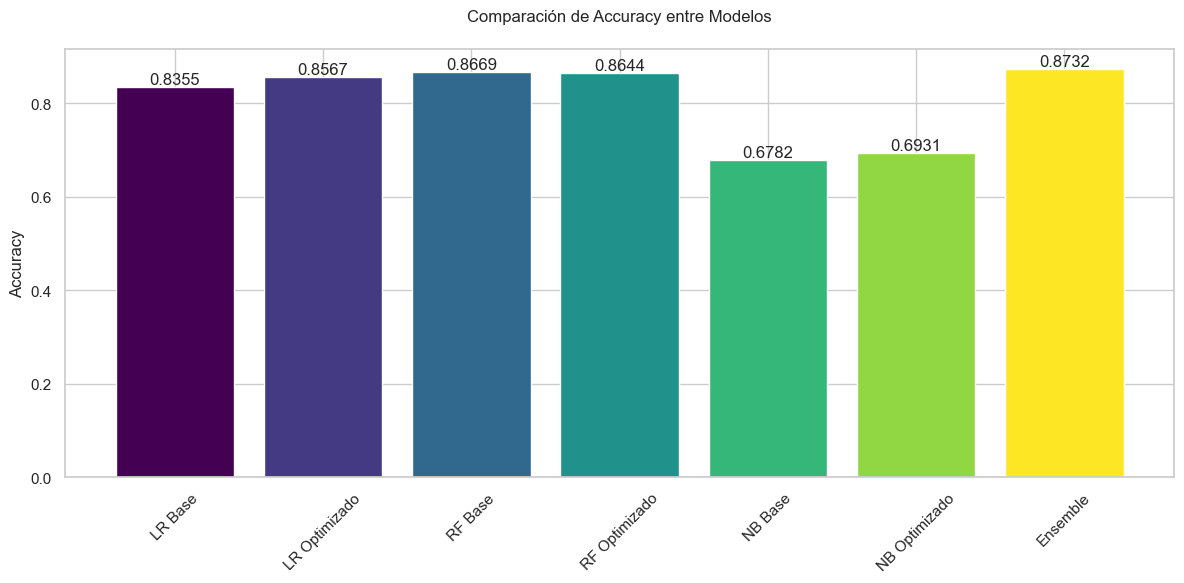

In [24]:
modelos = [
    'LR Base', 'LR Optimizado',
    'RF Base', 'RF Optimizado',
    'NB Base', 'NB Optimizado',
    'Ensemble'
]

accuracies = [0.8355, 0.8567, 0.8669, 0.8644, 0.6782, 0.6931, 0.8732]

# Crear colores usando viridis
n_bars = len(modelos)
colors = plt.cm.viridis(np.linspace(0, 1, n_bars))

# Crear gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(modelos, accuracies, color=colors)
plt.title('Comparación de Accuracy entre Modelos', pad=20)
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

# Añadir los valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

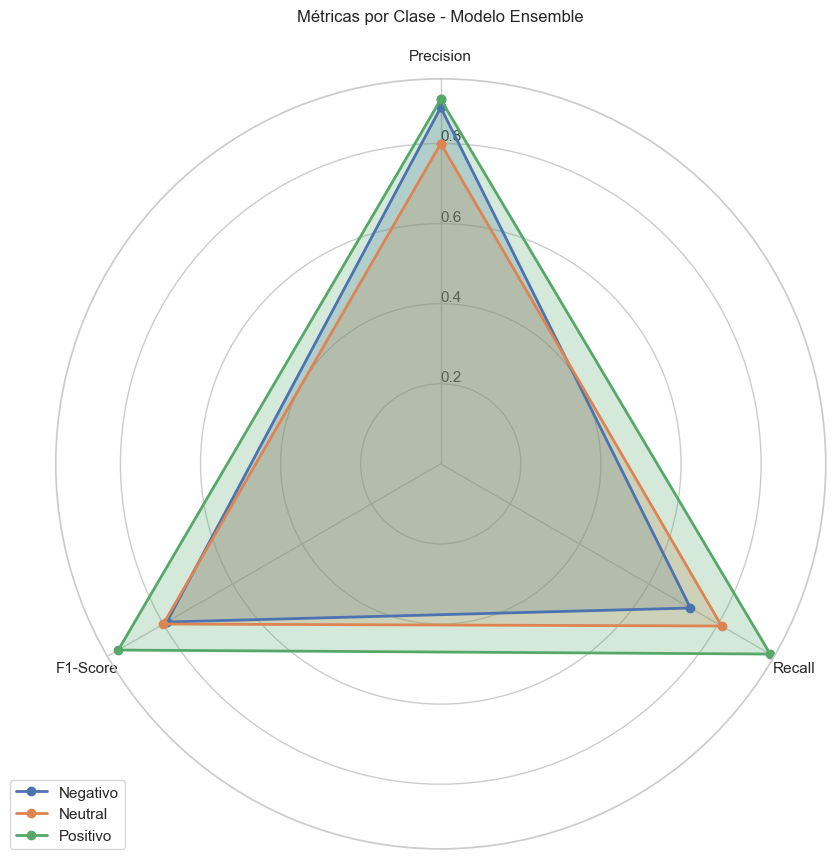

In [26]:
#Gráfico de radar para comparar métricas por clase del mejor modelo (Ensemble)
metricas = {
    'Negativo': [0.89, 0.72, 0.79],
    'Neutral': [0.80, 0.81, 0.80],
    'Positivo': [0.91, 0.95, 0.93]
}

# Crear el gráfico de radar
labels = ['Precision', 'Recall', 'F1-Score']
num_vars = len(labels)

angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for sentiment, scores in metricas.items():
    scores = scores + scores[:1]
    ax.plot(angles, scores, '-o', linewidth=2, label=sentiment)
    ax.fill(angles, scores, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

plt.xticks(angles[:-1], labels)
plt.title('Métricas por Clase - Modelo Ensemble', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()

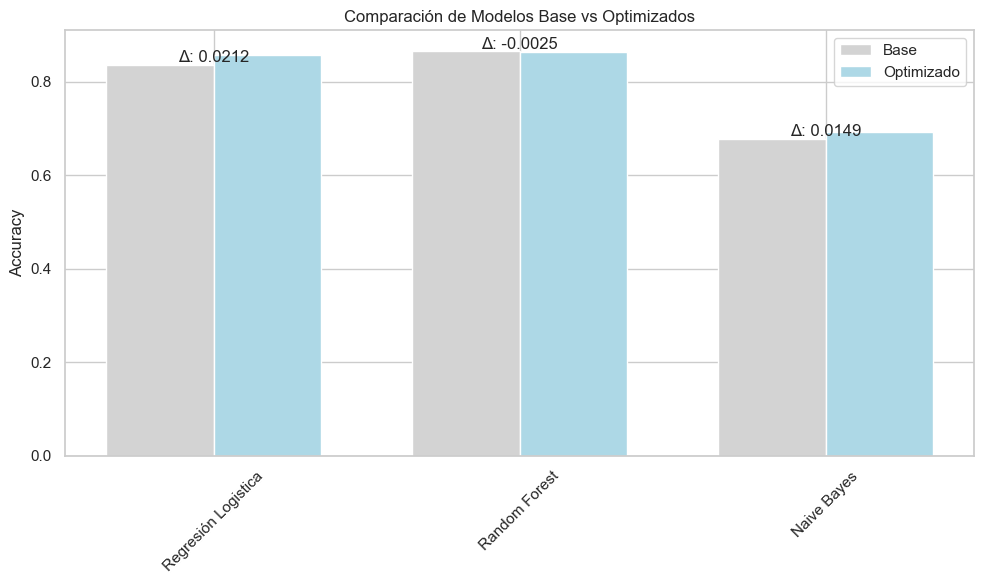

In [27]:
# Comparación de mejora después de optimización
modelos_base = ['Regresión Logistica', 'Random Forest', 'Naive Bayes']
accuracy_base = [0.8355, 0.8669, 0.6782]
accuracy_opt = [0.8567, 0.8644, 0.6931]

plt.figure(figsize=(10, 6))
x = range(len(modelos_base))
width = 0.35

plt.bar([i - width/2 for i in x], accuracy_base, width, label='Base', color='lightgray')
plt.bar([i + width/2 for i in x], accuracy_opt, width, label='Optimizado', color='lightblue')

plt.ylabel('Accuracy')
plt.title('Comparación de Modelos Base vs Optimizados')
plt.xticks(x, modelos_base, rotation=45)
plt.legend()

# Añadir las diferencias como texto
for i in range(len(modelos_base)):
    diff = accuracy_opt[i] - accuracy_base[i]
    plt.text(i, min(accuracy_base[i], accuracy_opt[i]), 
             f'Δ: {diff:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()